<a href="https://colab.research.google.com/github/a-pujahari/EVA7/blob/main/Session2.5/eva7_assignment_2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA 7 - Assignment 2.5 - Python 101 + Pytorch 101

## Create a NN to add random number to number detected from MNIST image

### Import Dependencies

In [1]:
!pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

### Check for CUDA - Always use GPU if available

In [3]:
# check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


### Import MNIST Dataset, Add Random numbers & Sums to create Test and Train Datasets

In [4]:
torch.manual_seed(1) ## Define seed so generation of random numbers remains same across multiple runs
batch_size = 128 ## Define batch size
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


class RandomMNISTDataset(Dataset):
    def __init__(self, MNISTDataset):
        self.MNISTDataset = MNISTDataset
        
    def __getitem__(self, index):
        image = self.MNISTDataset[index][0]
        label = self.MNISTDataset[index][1]
        randNum = torch.randint(0,9, (1,1))
        randNum_oneHot = F.one_hot(randNum, num_classes=10).type(torch.float32)
        sum = label + randNum
        return image, label, randNum_oneHot, sum

    def __len__(self):
        return len(self.MNISTDataset)

mnist_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
MNIST_trainset = torchvision.datasets.MNIST('/tmp', train=True, download=True, transform=mnist_transform)
MNIST_testset = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=mnist_transform)

train_dataset = RandomMNISTDataset(MNIST_trainset)
test_dataset = RandomMNISTDataset(MNIST_testset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#### Batch Shape

In [5]:
batch = next(iter(train_loader))

images, labels, randNum, sums = batch

images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [6]:
randNum[0], sums[0]

(tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]]), tensor([[11]]))

In [7]:
sums.squeeze()

tensor([11,  9, 10, 11, 15,  1,  2, 10,  2, 16, 11,  6,  7, 15,  3, 12,  9,  8,
        14, 15, 14,  6, 16, 12, 14,  4,  9,  4, 12, 13,  7, 11, 16, 12,  2,  5,
        11, 12,  9, 12,  5,  7,  6, 13,  5, 10,  3,  6,  5,  7,  2, 13, 12, 17,
        11,  3, 11,  9,  7,  8,  9,  8, 16, 10,  3, 10,  9,  5,  7, 16, 16,  5,
         9,  4, 10, 11,  3,  2,  8,  6,  8,  8, 16,  9, 14,  7,  7,  6,  4,  9,
         8,  8,  1,  2,  7, 14, 10, 14, 12, 14,  6, 11, 10, 12, 11, 14,  2, 11,
        16, 13,  9, 16, 14,  3,  6,  7,  5,  8,  5,  4, 11,  7,  8, 14,  1,  6,
         6, 11])

#### Visualize Batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([4, 8, 8, 6, 7, 1, 0, 7, 1, 8, 7, 6, 4, 9, 1, 5, 3, 2, 6, 8, 8, 6, 9, 4,
        6, 0, 4, 2, 6, 7])


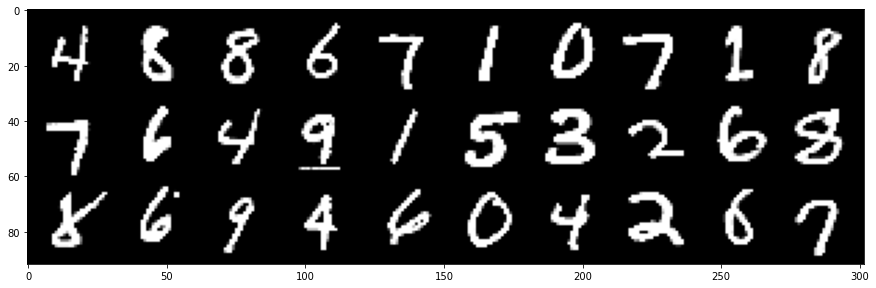

In [8]:
grid = torchvision.utils.make_grid(images[:30], nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels[:30])

### Define Neural Network

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc_rand1 = nn.Linear(in_features = 10, out_features = 20)
        self.fc1 = nn.Linear(in_features=192+20, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=29)
    
    def forward(self, image, randNum):
        ## Input Layer
        x = image
        
        ## Conv layer 1
        x = self.conv1(x) ## Input image 28x28x1, Output 24x24x6
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2) ## Input 24x24x6, Output 12x12x6
        
        ## Conv layer 2
        x = self.conv2(x) ## Input 12x12x6, Output 8x8x12
        x = F.relu(x)
        x = F.max_pool2d(x,kernel_size=2,stride=2) ## Input 8x8x12, Output 4x4x12
        
        ## Reshape
        x = x.reshape(-1, 12*4*4)
        
        ## Process random number
        y = randNum.type(torch.float32)
        ## Pass one hot encoded random number through fully connected layer 10>20 neurons
        y = self.fc_rand1(y)
        y = F.relu(y)
        y = y.reshape(-1, 20)
        
        ## Concatenate MNIST convolution output with Random Number fc output
        x1 = torch.cat((x, y), dim = 1)
        
        ## Fully connected layers
        x1 = self.fc1(x1)
        x1 = F.relu(x1)
        
        x1 = self.fc2(x1)
        x1 = F.relu(x1)
        x1 = self.out(x1)
        
        #print(x1.shape)
        mnist_output = F.softmax(x1[:,0:10])
        sum_output = F.softmax(x1[:,10:])
        
        return mnist_output, sum_output

#### Model Summary

In [10]:
model = Net().to(device)
summary(model, [(1,28, 28),(1,1,10)])
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
            Conv2d-2             [-1, 12, 8, 8]           1,812
            Linear-3             [-1, 1, 1, 20]             220
            Linear-4                  [-1, 100]          21,300
            Linear-5                   [-1, 60]           6,060
            Linear-6                   [-1, 29]           1,769
Total params: 31,317
Trainable params: 31,317
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.03
Params size (MB): 0.12
Estimated Total Size (MB): 0.18
----------------------------------------------------------------
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc_rand1): Linear(in_features=10, out_feature

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [11]:
test = torch.randint(0,9,(1,1))
print(test[0,0:10])
test1 = F.one_hot(test, num_classes =10)
print(test1)

tensor([5])
tensor([[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]])


In [12]:
images, labels, randNum, sums = images.to(device), labels.to(device), randNum.to(device), sums.to(device)
mnist_pred, sum_pred = model(images, randNum)
mnist_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[0.1107, 0.0925, 0.1054,  ..., 0.0869, 0.0989, 0.0980],
        [0.1113, 0.0935, 0.1033,  ..., 0.0866, 0.1012, 0.0972],
        [0.1119, 0.0926, 0.1038,  ..., 0.0884, 0.0986, 0.1011],
        ...,
        [0.1146, 0.0943, 0.1053,  ..., 0.0900, 0.0978, 0.0974],
        [0.1111, 0.0940, 0.1063,  ..., 0.0861, 0.1009, 0.1001],
        [0.1105, 0.0919, 0.1038,  ..., 0.0896, 0.0971, 0.0983]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [13]:
mnist_pred.shape, sum_pred.shape ## Shapes of outputs are defined by batch size

(torch.Size([128, 10]), torch.Size([128, 19]))

In [14]:
mnist_pred[0].sum() ## Each row must sum to 1, considering softmax function has been applied to equate values to probabilities

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [15]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

correct_mnist = get_num_correct(mnist_pred, labels)
print(correct_mnist, " out of ",  len(labels), " correct")

11  out of  128  correct


### Define Train & Test Functions

In [16]:
from tqdm import tqdm
torch.set_grad_enabled(True)

In [17]:
## Define training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (images, labels, randNum, sums) in enumerate(pbar):
        images, labels, randNum, sums = images.to(device), labels.to(device), randNum.to(device), sums.to(device)
        ## Zero out all gradients to prevent accumulation
        optimizer.zero_grad()
        ## Forward pass
        mnist_output, sum_output = model(images, randNum)
        
        ## Calculate loss
        MNIST_loss = F.cross_entropy(mnist_output, labels)
        sum_loss = F.cross_entropy(sum_output, sums.squeeze())
        loss = (MNIST_loss + sum_loss)
        
        ## Backpropagation
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

In [18]:
## Define testing function
def test(model, device, test_loader):
    model.eval()
    test_loss, mnist_test_loss, sums_test_loss  = 0, 0, 0
    correct_mnist, correct_sums = 0, 0
    
    with torch.no_grad():
        for images, labels, randNum, sums in test_loader:
            
            images, labels, randNum, sums = images.to(device), labels.to(device), randNum.to(device), sums.to(device)
            ## Forward pass
            mnist_output, sum_output = model(images, randNum)
            
            ## Calculate loss
            mnist_test_loss += F.cross_entropy(mnist_output, labels, reduction='sum').item()  
            sums_test_loss += F.cross_entropy(sum_output, sums.squeeze(), reduction='sum').item()
            
            correct_mnist = get_num_correct(mnist_output, labels)

            correct_sums = get_num_correct(sum_output, sums.squeeze())

    test_loss = mnist_test_loss + sums_test_loss
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average MNIST loss: {:.4f}, MNIST_Accuracy: {}/{} ({:.0f}%)\n'.format(
        mnist_test_loss, correct_mnist, len(test_loader.dataset),
        100. * correct_mnist / len(test_loader.dataset)))
    
    print('\nTest set: Average SUM loss: {:.4f}, SUM_Accuracy: {}/{} ({:.0f}%)\n'.format(
        sums_test_loss, correct_sums, len(test_loader.dataset),
        100. * correct_sums / len(test_loader.dataset)))

### Train & Test Network

In [19]:
'''
Neural network is unable to learn because of random number FC output being added to MNIST convolution ouput and then being
passed through a series of fully connected layers. 
Lack of a discernible pattern with the random numbers generated leads to the sum output being random as well; with the neural
network having no specific pattern/characteristics/properties to learn and exploit to create a reliable prediction.
'''
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
tqdm._instances.clear() ## Clear any extraneous tqdm instances to ensure printing on the same line


epochs = 30
for epoch in range(1, epochs):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
loss=4.416330814361572 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.05it/s]



Test set: Average MNIST loss: 15163.1910, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 29104.2359, SUM_Accuracy: 2/10000 (0%)



loss=4.428135871887207 batch_id=468: 100%|██████████| 469/469 [00:39<00:00, 11.98it/s]



Test set: Average MNIST loss: 14851.3188, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 29064.1472, SUM_Accuracy: 2/10000 (0%)



loss=4.405933380126953 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]



Test set: Average MNIST loss: 14842.8050, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 28963.9359, SUM_Accuracy: 1/10000 (0%)



loss=4.390820503234863 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.08it/s]



Test set: Average MNIST loss: 14788.1913, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 28958.6352, SUM_Accuracy: 2/10000 (0%)



loss=4.411187648773193 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.10it/s]



Test set: Average MNIST loss: 14756.3758, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 28965.5996, SUM_Accuracy: 1/10000 (0%)



loss=4.356391429901123 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.07it/s]



Test set: Average MNIST loss: 14764.9039, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 28958.9466, SUM_Accuracy: 1/10000 (0%)



loss=4.374413013458252 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.05it/s]



Test set: Average MNIST loss: 14759.0173, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 28951.6818, SUM_Accuracy: 1/10000 (0%)



loss=4.355350017547607 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.10it/s]



Test set: Average MNIST loss: 14725.5267, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 28915.7633, SUM_Accuracy: 1/10000 (0%)



loss=4.2676520347595215 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.04it/s]



Test set: Average MNIST loss: 14808.3860, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 27875.4019, SUM_Accuracy: 4/10000 (0%)



loss=4.033755302429199 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.09it/s]



Test set: Average MNIST loss: 14779.9032, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 26286.9281, SUM_Accuracy: 7/10000 (0%)



loss=4.0846333503723145 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.14it/s]



Test set: Average MNIST loss: 14807.1184, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25942.2989, SUM_Accuracy: 10/10000 (0%)



loss=4.044963359832764 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]



Test set: Average MNIST loss: 14772.8851, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25726.8947, SUM_Accuracy: 7/10000 (0%)



loss=4.058967590332031 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.14it/s]



Test set: Average MNIST loss: 14747.8515, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25749.3713, SUM_Accuracy: 9/10000 (0%)



loss=4.005923748016357 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.25it/s]



Test set: Average MNIST loss: 14748.1152, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25777.6574, SUM_Accuracy: 7/10000 (0%)



loss=4.144825458526611 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.15it/s]



Test set: Average MNIST loss: 14733.4145, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25787.1875, SUM_Accuracy: 11/10000 (0%)



loss=4.09298849105835 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.11it/s]



Test set: Average MNIST loss: 14746.2118, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25741.1682, SUM_Accuracy: 5/10000 (0%)



loss=4.027492046356201 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.11it/s]



Test set: Average MNIST loss: 14721.8665, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25813.8111, SUM_Accuracy: 8/10000 (0%)



loss=4.106172561645508 batch_id=468: 100%|██████████| 469/469 [00:39<00:00, 12.02it/s]



Test set: Average MNIST loss: 14739.0707, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25669.7714, SUM_Accuracy: 7/10000 (0%)



loss=4.033599376678467 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.14it/s]



Test set: Average MNIST loss: 14735.7439, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25712.5564, SUM_Accuracy: 6/10000 (0%)



loss=4.011661529541016 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.04it/s]



Test set: Average MNIST loss: 14732.4002, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25676.8034, SUM_Accuracy: 7/10000 (0%)



loss=4.105088710784912 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.11it/s]



Test set: Average MNIST loss: 14760.0181, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25728.5309, SUM_Accuracy: 9/10000 (0%)



loss=4.074320316314697 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.10it/s]



Test set: Average MNIST loss: 14750.1925, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25754.0281, SUM_Accuracy: 10/10000 (0%)



loss=3.909430742263794 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.16it/s]



Test set: Average MNIST loss: 14714.2195, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25627.4471, SUM_Accuracy: 12/10000 (0%)



loss=4.126588344573975 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.14it/s]



Test set: Average MNIST loss: 14743.1375, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25696.2251, SUM_Accuracy: 6/10000 (0%)



loss=4.071372032165527 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.03it/s]



Test set: Average MNIST loss: 14747.9719, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25649.2948, SUM_Accuracy: 8/10000 (0%)



loss=4.0962443351745605 batch_id=468: 100%|██████████| 469/469 [00:39<00:00, 11.96it/s]



Test set: Average MNIST loss: 14725.8855, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25692.7561, SUM_Accuracy: 10/10000 (0%)



loss=4.081849098205566 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.11it/s]



Test set: Average MNIST loss: 14728.4640, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25754.7220, SUM_Accuracy: 9/10000 (0%)



loss=4.124319553375244 batch_id=468: 100%|██████████| 469/469 [00:38<00:00, 12.14it/s]



Test set: Average MNIST loss: 14739.1799, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25644.7474, SUM_Accuracy: 7/10000 (0%)



loss=3.979915142059326 batch_id=468: 100%|██████████| 469/469 [00:39<00:00, 12.00it/s]



Test set: Average MNIST loss: 14719.3269, MNIST_Accuracy: 16/10000 (0%)


Test set: Average SUM loss: 25656.0117, SUM_Accuracy: 5/10000 (0%)

